In [1]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [2]:
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()
# import tensorflow as tf

# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Analysis

In [3]:
%cd /content/drive/MyDrive/AI/TemperatureForecast

/content/drive/MyDrive/AI/TemperatureForecast


In [4]:
df = pd.read_csv("data/filled_weather0721.csv")

In [5]:
import datetime
# Converting the dt column to datetime object 
df['time'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['time']]

# Sorting by the date 
df.sort_values('time', inplace=True)
print(f"First date {min(df['time'])}")
print(f"Most recent date {max(df['time'])}")

First date 2007-01-01 00:00:00
Most recent date 2021-12-31 23:30:00


In [6]:
features = ['temp', 'humidity']

# Creating the data column
df['date'] = [x.date() for x in df['time']]

df[features].describe()

,temp,humidity
count,262992.000000,262992.000000
mean,24.400541,77.453843
std,5.744766,15.794014
min,5.000000,3.000000
25%,20.000000,66.000000
50%,25.000000,79.000000
75%,28.000000,89.000000
max,41.000000,100.000000


## Half-Hourly Data Plot

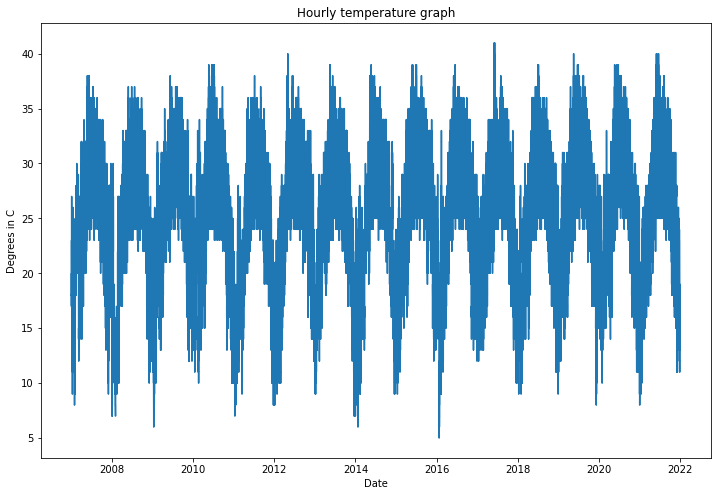

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot('time', 'temp', data=df)
plt.title('Hourly temperature graph')
plt.ylabel('Degrees in C')
plt.xlabel('Date')
plt.show()

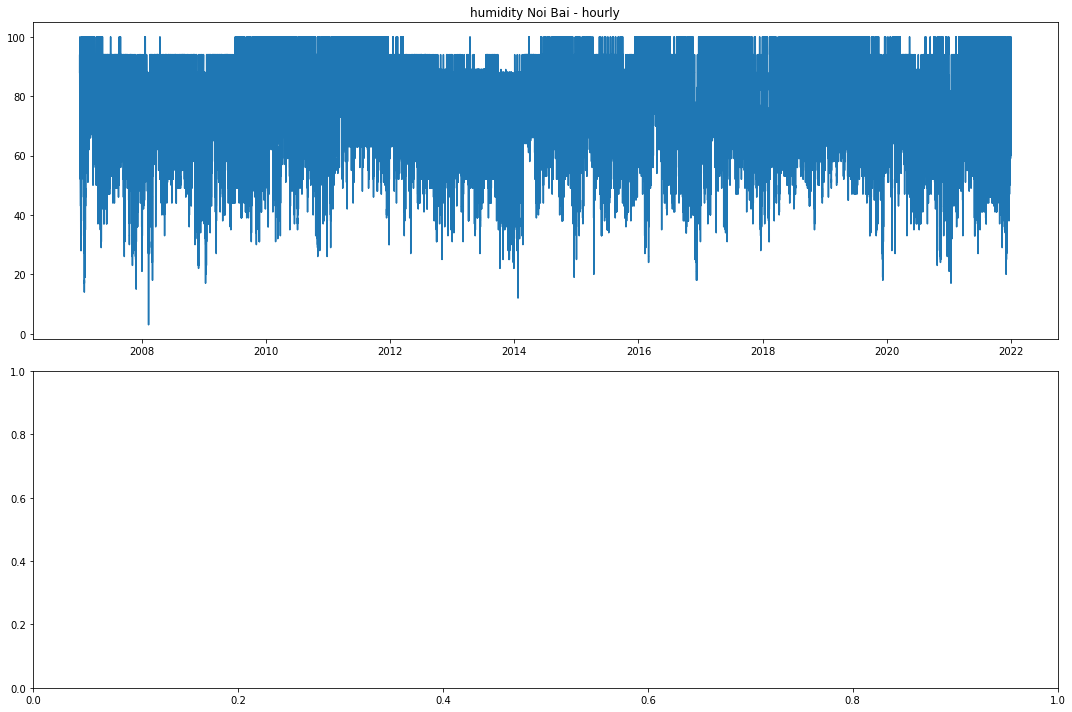

In [16]:
plot_features = df[features]
plot_features.index = df.time

fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(['humidity']):
    axes[i % 2].plot(plot_features[feature])
    axes[i % 2].set_title(f'{feature} Noi Bai - hourly')
        
plt.tight_layout()

plt.show()

## Daily Data

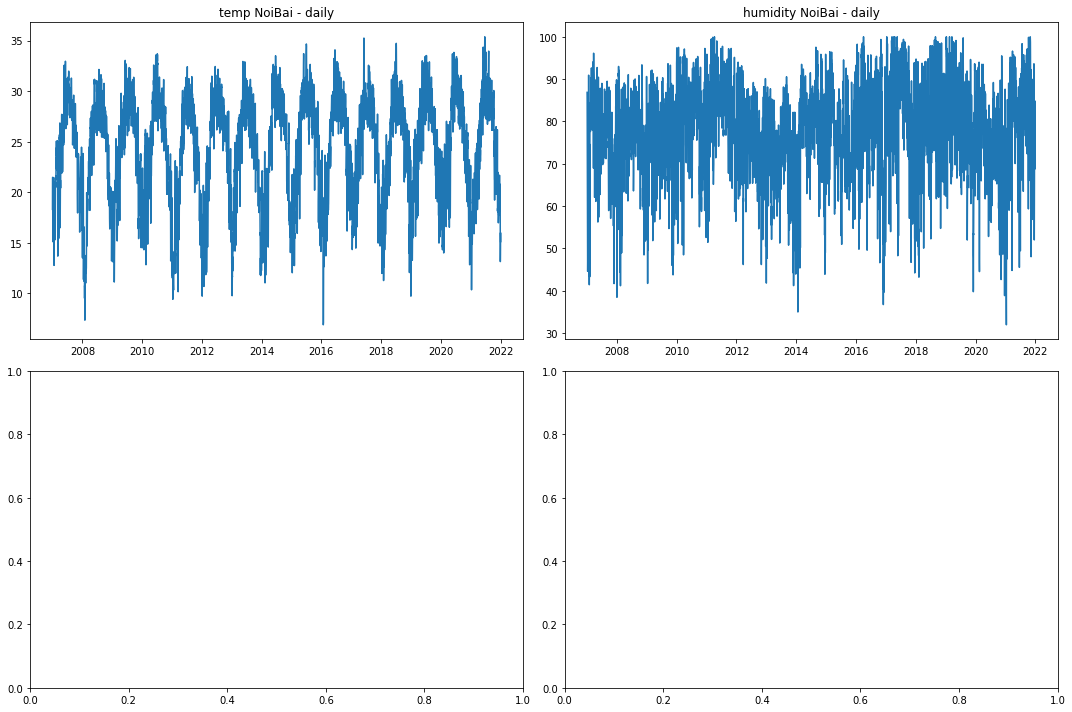

In [17]:
plot_features = df.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} NoiBai - daily')
        
plt.tight_layout()

plt.show()

## Heatmaps

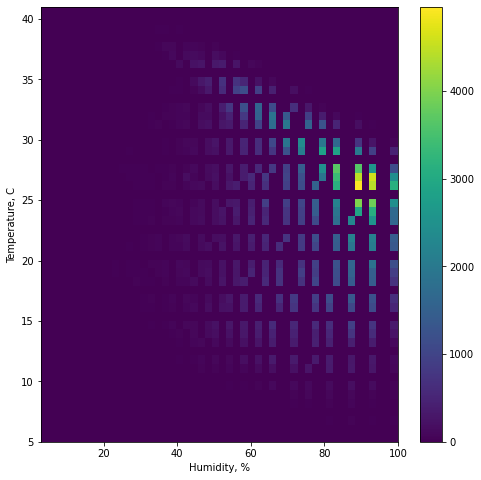

In [18]:
plt.figure(figsize=(8, 8))
plt.hist2d(df['humidity'], df['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Humidity, %')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

#Feature Engineering

In [7]:
# Extracting the hour of day
df['hour'] = [x.hour for x in df['time']]

# Extracting the month of the year 
df['month'] = [x.month for x in df['time']]

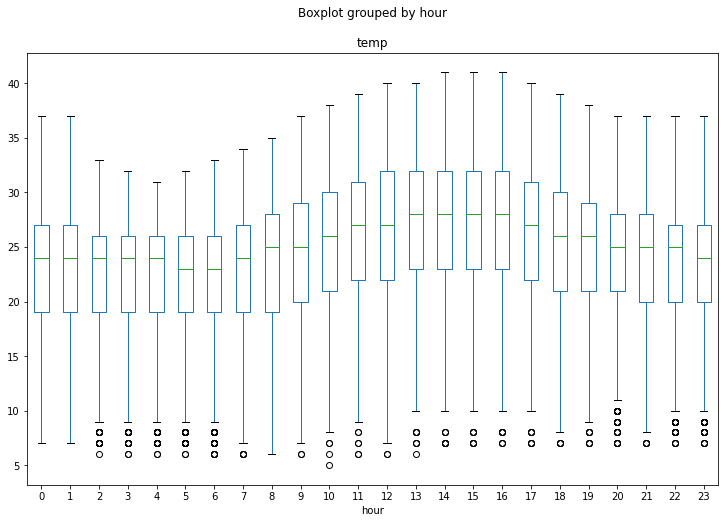

In [80]:
df.boxplot('temp', by='hour', figsize=(12, 8), grid=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


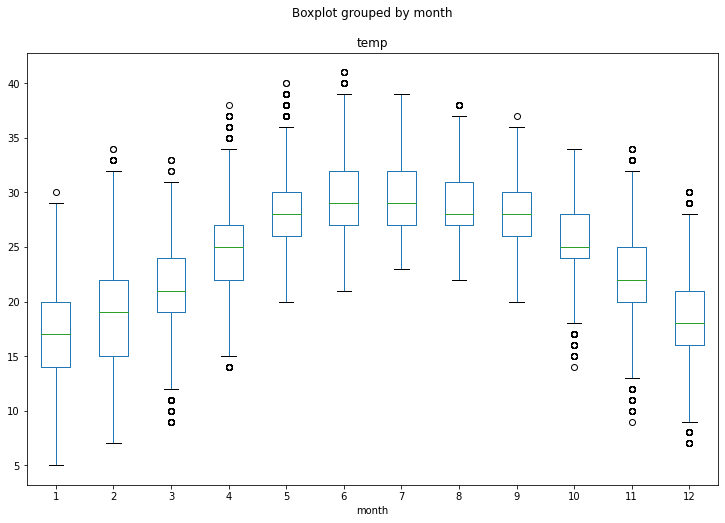

In [81]:
df.boxplot('temp', by='month', figsize=(12, 8), grid=False)

In [8]:
# Creating the cyclical daily feature 
df['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in df['hour']]
df['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in df['hour']]

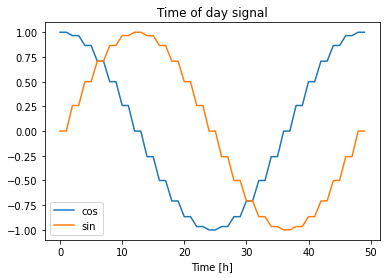

In [83]:
# Ploting the first 25 hours 
plt.plot(np.array(df['day_cos'])[:50], label='cos')
plt.plot(np.array(df['day_sin'])[:50], label='sin')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

In [9]:
# Extracting the timestamp from the datetime object 
df['timestamp'] = [x.timestamp() for x in df['time']]

# Seconds in day 
s = 24 * 60 * 60 

# Seconds in year 
year = (365.25) * s

df['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in df['timestamp']]
df['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in df['timestamp']]

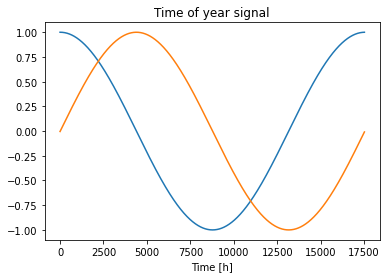

In [25]:
# Ploting the first year
plt.plot(np.array(df['month_cos'])[:48 * 365])
plt.plot(np.array(df['month_sin'])[:48 * 365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.show()

# Single Step Forecast

## Hyper Parameter

In [129]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 25

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 15

# The features used in the modeling 
features_final = ['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'humidity']

## Creating the matrices for learning

In [11]:
df[features_final].head(10)

,temp,day_cos,day_sin,month_sin,month_cos,humidity
0,18.0,1.000000,0.000000,-0.004301,0.999991,88.0
1,18.0,1.000000,0.000000,-0.003942,0.999992,83.0
2,18.0,0.965926,0.258819,-0.003584,0.999994,88.0
3,18.0,0.965926,0.258819,-0.003225,0.999995,88.0
4,18.0,0.866025,0.500000,-0.002867,0.999996,88.0
5,18.0,0.866025,0.500000,-0.002509,0.999997,88.0
6,18.0,0.707107,0.707107,-0.002150,0.999998,88.0
7,18.0,0.707107,0.707107,-0.001792,0.999998,88.0
8,18.0,0.500000,0.866025,-0.001434,0.999999,83.0
9,18.0,0.500000,0.866025,-0.001075,0.999999,83.0


In [12]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    print(f"n_features: {n_features:d}")
    
    # Creating placeholder lists
    X, Y = [], []

    print(f"len(ts): {len(ts):d}")
    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [13]:
# Subseting only the needed columns 
ts = df[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

In [14]:
print(ts_s.head())
# print(ts_s.values)
# print(len(ts_s.values))
# ts_s.count()

       temp   day_cos   day_sin  month_sin  month_cos  humidity
0 -1.100053  1.414176 -0.000003  -0.039448   1.414078  0.663376
1 -1.100053  1.414176 -0.000003  -0.038941   1.414080  0.340915
2 -1.100053  1.365988  0.366024  -0.038434   1.414082  0.663376
3 -1.100053  1.365988  0.366024  -0.037927   1.414084  0.663376
4 -1.100053  1.224709  0.707108  -0.037420   1.414085  0.663376


In [15]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead,target_index=[0,5])

n_ft = X.shape[2]

n_features: 6
len(ts): 262992


In [16]:
Y.shape

(262943, 1, 2)

In [17]:
# print(Y)
# Y = np.reshape(Y,(2*Y.shape[0],1))
# print("=========================")
# print(Y)

In [18]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

# Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:2*int(X.shape[0] * (1 - test_share))]
# Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[2*int(X.shape[0] * (1 - test_share)):]

In [19]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (236648, 48, 6)
Shape of the target data: (236648, 1, 2)
Shape of validation data: (26295, 48, 6)
Shape of the validation target data: (26295, 1, 2)


## Defining the model

In [130]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [132]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=2*n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [133]:
model.model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 6)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 15)                1320      
                                                                 
 dense_6 (Dense)             (None, 2)                 32        
                                                                 
Total params: 1,352
Trainable params: 1,352
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.train()

Epoch 1/25
463/463 [==============================] - 32s 65ms/step - loss: 0.6651 - val_loss: 0.6722
Epoch 2/25
463/463 [==============================] - 28s 60ms/step - loss: 0.6225 - val_loss: 0.6674
Epoch 3/25
463/463 [==============================] - 29s 62ms/step - loss: 0.6192 - val_loss: 0.6661
Epoch 4/25
463/463 [==============================] - 28s 60ms/step - loss: 0.6176 - val_loss: 0.6654
Epoch 5/25
463/463 [==============================] - 27s 59ms/step - loss: 0.6167 - val_loss: 0.6651
Epoch 6/25
463/463 [==============================] - 28s 60ms/step - loss: 0.6161 - val_loss: 0.6648
Epoch 7/25
463/463 [==============================] - 28s 60ms/step - loss: 0.6157 - val_loss: 0.6646
Epoch 8/25
463/463 [==============================] - 27s 59ms/step - loss: 0.6153 - val_loss: 0.6645
Epoch 9/25
463/463 [==============================] - 27s 59ms/step - loss: 0.6149 - val_loss: 0.6644
Epoch 10/25
463/463 [==============================] - 28s 61ms/step - loss: 0.614

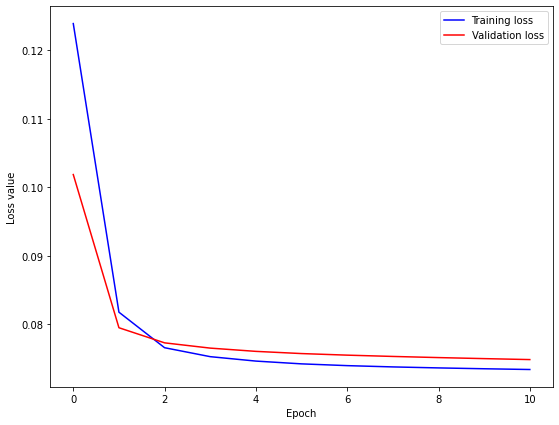

In [113]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [114]:
# Comparing the forecasts with the actual values
# yhat = [x[0] for x in model.predict(Xval)]
yhat = model.predict(Xval)
y = Yval
# tmp_y_hat = model.predict(Xval)
# tmp_y_hat.shape
# Yval

In [115]:
# print(Yval)
# y_temp = Yval[:,:,0]
# y_temp = y_temp.T
y_temp[0]

array([ 0.46454462,  0.46454462,  0.29070047, ..., -1.44774111,
       -1.44774111, -1.44774111])

In [116]:
# Creating the frame to store both predictions
days = df['time'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y[:,:,0].T[0],"humidity":y[:,:,1].T[0], 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat[:,0],"humidity":yhat[:,1], 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
frame['humidity_absolute'] = [(x * train_std['humidity']) + train_mean['humidity'] for x in frame['humidity']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['temp_res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['humidity_res'] = pivoted['humidity_absolute_original'] - pivoted['humidity_absolute_forecast']
pivoted['temp_res_abs'] = [abs(x) for x in pivoted['temp_res']]
pivoted['humidity_res_abs'] = [abs(x) for x in pivoted['humidity_res']]

In [117]:
pivoted.tail(10)

,humidity_forecast,humidity_original,humidity_absolute_forecast,humidity_absolute_original,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,temp_res,humidity_res,temp_res_abs,humidity_res_abs
day,,,,,,,,,,,,
2021-12-31 19:00:00,0.332324,0.276423,82.866785,82.0,-0.631237,-1.447741,20.696759,16.0,-4.696759,-0.866785,4.696759,0.866785
2021-12-31 19:30:00,0.329980,0.276423,82.830446,82.0,-0.608927,-1.447741,20.825094,16.0,-4.825094,-0.830446,4.825094,0.830446
2021-12-31 20:00:00,0.324913,0.276423,82.751879,82.0,-0.622393,-1.447741,20.747632,16.0,-4.747632,-0.751879,4.747632,0.751879
2021-12-31 20:30:00,0.322018,0.276423,82.706985,82.0,-0.600514,-1.447741,20.873486,16.0,-4.873486,-0.706985,4.873486,0.706985
2021-12-31 21:00:00,0.317037,0.276423,82.629752,82.0,-0.602816,-1.447741,20.860243,16.0,-4.860243,-0.629752,4.860243,0.629752
2021-12-31 21:30:00,0.314712,0.276423,82.593692,82.0,-0.584003,-1.447741,20.968462,16.0,-4.968462,-0.593692,4.968462,0.593692
2021-12-31 22:00:00,0.310959,0.276423,82.535501,82.0,-0.577924,-1.447741,21.003428,16.0,-5.003428,-0.535501,5.003428,0.535501
2021-12-31 22:30:00,0.309212,0.276423,82.508424,82.0,-0.564480,-1.447741,21.080762,16.0,-5.080762,-0.508424,5.080762,0.508424
2021-12-31 23:00:00,0.304350,0.276423,82.433025,82.0,-0.554912,-1.447741,21.135800,16.0,-5.135800,-0.433025,5.135800,0.433025


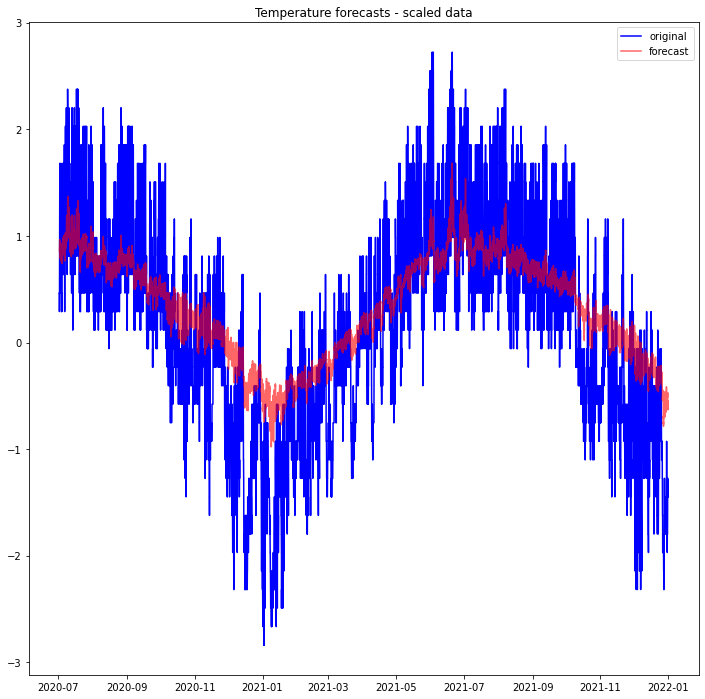

In [118]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - scaled data')
plt.legend()
plt.show()

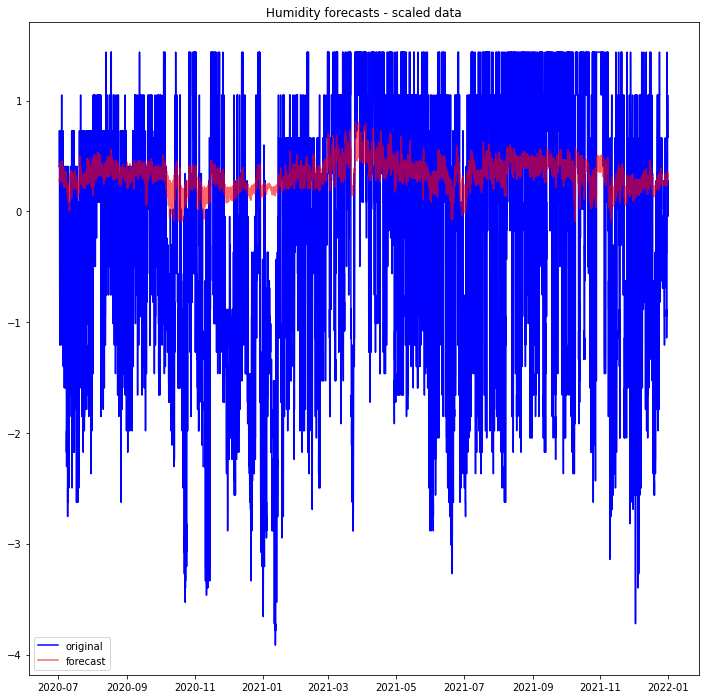

In [119]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.humidity_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.humidity_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Humidity forecasts - scaled data')
plt.legend()
plt.show()

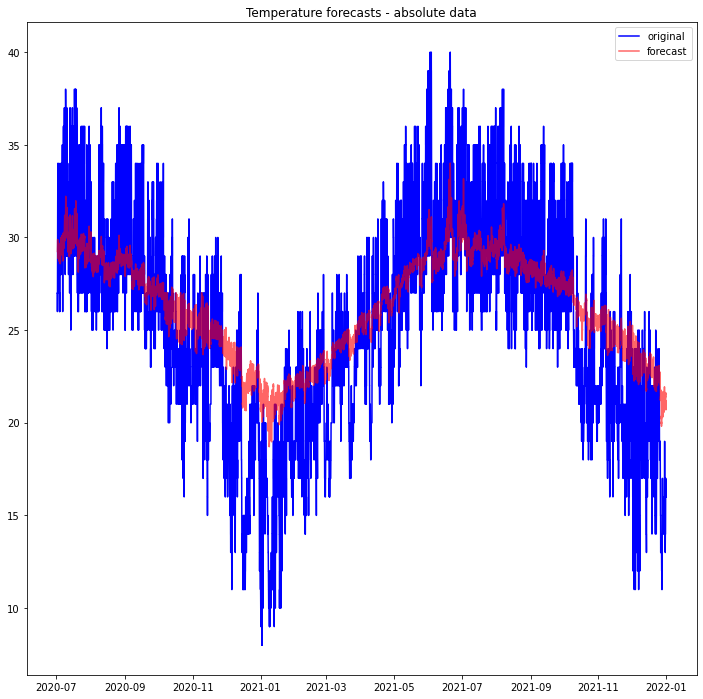

In [120]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

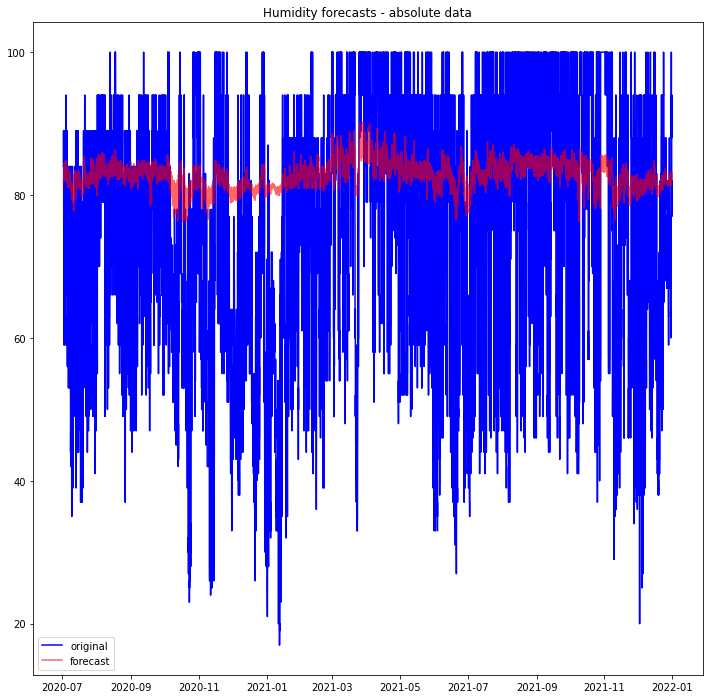

In [121]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.humidity_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.humidity_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Humidity forecasts - absolute data')
plt.legend()
plt.show()

In [122]:
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['temp_res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['temp_res_abs'] = [abs(x) for x in pivoted['temp_res']]
pivoted['humidity_res'] = pivoted['humidity_absolute_original'] - pivoted['humidity_absolute_forecast']
pivoted['humidity_res_abs'] = [abs(x) for x in pivoted['humidity_res']]

In [123]:
pivoted.tail(10)

,humidity_forecast,humidity_original,humidity_absolute_forecast,humidity_absolute_original,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,temp_res,temp_res_abs,humidity_res,humidity_res_abs
day,,,,,,,,,,,,
2021-12-31 19:00:00,0.332324,0.276423,82.866785,82.0,-0.631237,-1.447741,20.696759,16.0,-4.696759,4.696759,-0.866785,0.866785
2021-12-31 19:30:00,0.329980,0.276423,82.830446,82.0,-0.608927,-1.447741,20.825094,16.0,-4.825094,4.825094,-0.830446,0.830446
2021-12-31 20:00:00,0.324913,0.276423,82.751879,82.0,-0.622393,-1.447741,20.747632,16.0,-4.747632,4.747632,-0.751879,0.751879
2021-12-31 20:30:00,0.322018,0.276423,82.706985,82.0,-0.600514,-1.447741,20.873486,16.0,-4.873486,4.873486,-0.706985,0.706985
2021-12-31 21:00:00,0.317037,0.276423,82.629752,82.0,-0.602816,-1.447741,20.860243,16.0,-4.860243,4.860243,-0.629752,0.629752
2021-12-31 21:30:00,0.314712,0.276423,82.593692,82.0,-0.584003,-1.447741,20.968462,16.0,-4.968462,4.968462,-0.593692,0.593692
2021-12-31 22:00:00,0.310959,0.276423,82.535501,82.0,-0.577924,-1.447741,21.003428,16.0,-5.003428,5.003428,-0.535501,0.535501
2021-12-31 22:30:00,0.309212,0.276423,82.508424,82.0,-0.564480,-1.447741,21.080762,16.0,-5.080762,5.080762,-0.508424,0.508424
2021-12-31 23:00:00,0.304350,0.276423,82.433025,82.0,-0.554912,-1.447741,21.135800,16.0,-5.135800,5.135800,-0.433025,0.433025


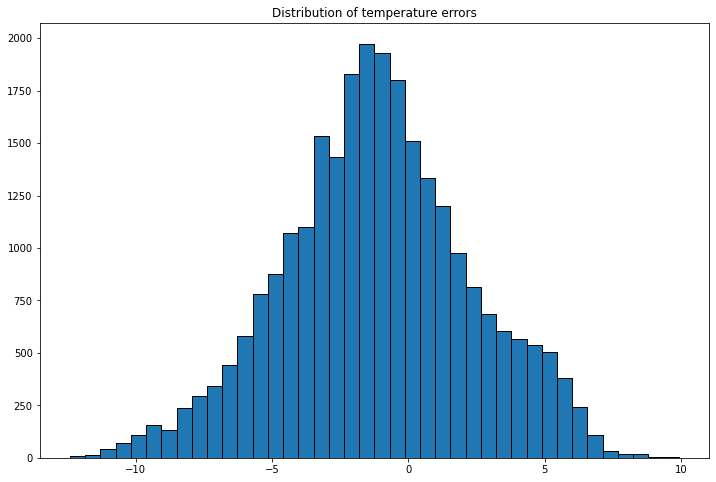

In [124]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.temp_res, bins=40, edgecolor='black')
plt.title('Distribution of temperature errors')
plt.show()

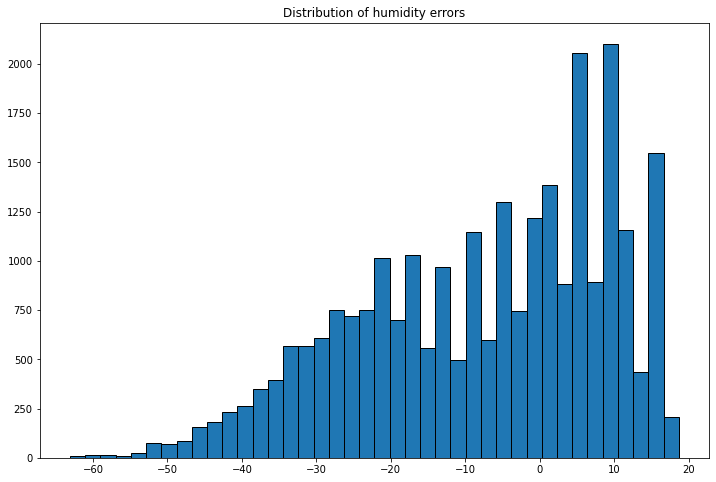

In [125]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.humidity_res, bins=40, edgecolor='black')
plt.title('Distribution of humidity errors')
plt.show()

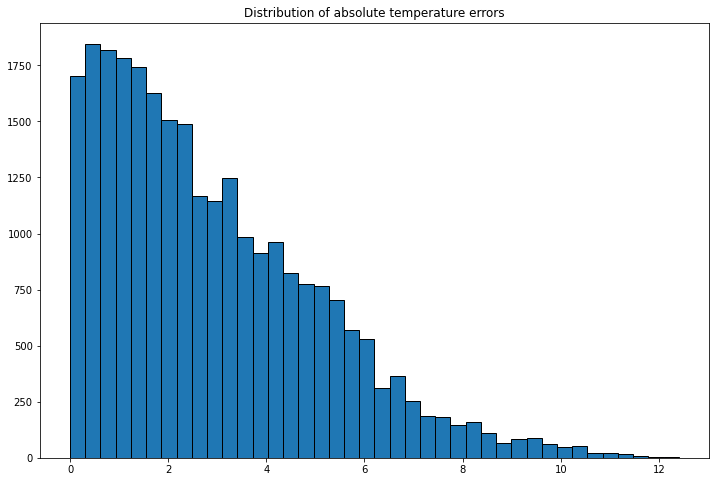

In [126]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.temp_res_abs, bins=40, edgecolor='black')
plt.title('Distribution of absolute temperature errors')
plt.show()

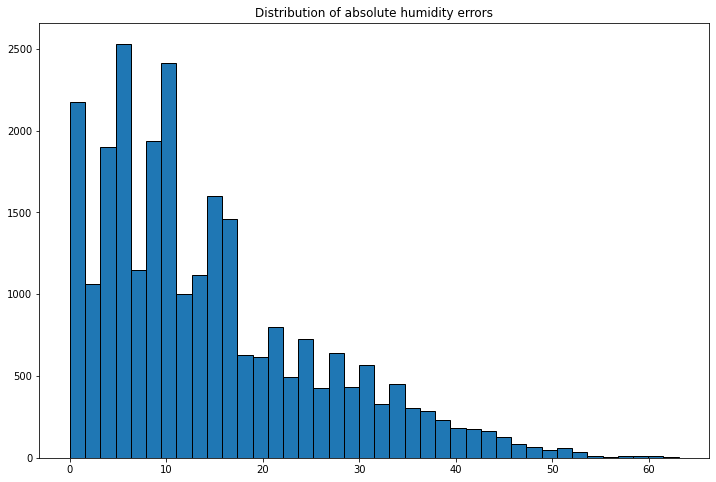

In [127]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.humidity_res_abs, bins=40, edgecolor='black')
plt.title('Distribution of absolute humidity errors')
plt.show()

In [128]:
print(pivoted.temp_res_abs.describe())
print(pivoted.humidity_res_abs.describe())

count    26295.000000
mean         2.905361
std          2.198893
min          0.000099
25%          1.152608
50%          2.403476
75%          4.267023
max         12.403450
Name: temp_res_abs, dtype: float64
count    26295.000000
mean        14.477902
std         11.410797
min          0.000062
25%          5.651883
50%         11.019214
75%         20.665473
max         63.078052
Name: humidity_res_abs, dtype: float64


# Sequence Prediction

In [ ]:
# Number of lags (hours back) to use for models
lag = 168

# Steps ahead to forecast 
n_ahead = 24

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

In [ ]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [ ]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (236520, 168, 6)
Shape of the target data: (236520, 24)
Shape of validation data: (26280, 168, 6)
Shape of the validation target data: (26280, 24)


In [ ]:
seq_model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [ ]:
seq_model.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 168, 6)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                680       
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
Total params: 944
Trainable params: 944
Non-trainable params: 0
_________________________________________________________________


In [ ]:
seq_history = seq_model.train()

Epoch 1/20
462/462 [==============================] - 68s 142ms/step - loss: 149.6529 - val_loss: 0.7919
Epoch 2/20
462/462 [==============================] - 67s 145ms/step - loss: 0.7078 - val_loss: 0.5708
Epoch 3/20
462/462 [==============================] - 47s 102ms/step - loss: 0.5753 - val_loss: 0.4985
Epoch 4/20
462/462 [==============================] - 49s 105ms/step - loss: 0.5112 - val_loss: 0.4551
Epoch 5/20
462/462 [==============================] - 48s 104ms/step - loss: 0.4726 - val_loss: 0.4325
Epoch 6/20
462/462 [==============================] - 48s 103ms/step - loss: 0.4542 - val_loss: 0.4169
Epoch 7/20
462/462 [==============================] - 47s 102ms/step - loss: 0.4329 - val_loss: 0.3990
Epoch 8/20
462/462 [==============================] - 48s 103ms/step - loss: 0.4113 - val_loss: 0.3882
Epoch 9/20
462/462 [==============================] - 47s 102ms/step - loss: 0.4026 - val_loss: 0.3792
Epoch 10/20
462/462 [==============================] - 47s 101ms/step -

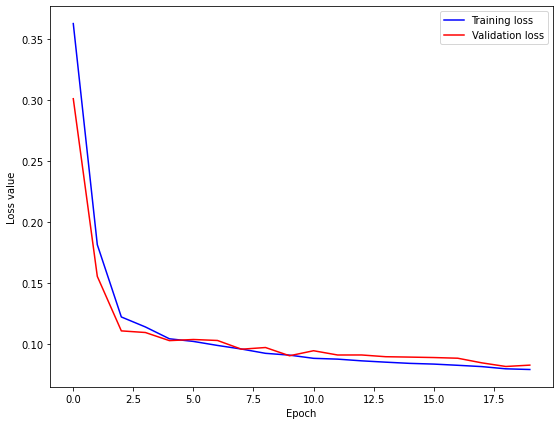

In [ ]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Forecasting on all the samples in the validation set 
forecast = seq_model.predict(Xval)

ValueError: ignored

In [ ]:
fig, axes = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(15, 15), 
    facecolor="w", 
    edgecolor="k"
)

indexes = random.sample(range(len(forecast)), 8)

for i, index in enumerate(indexes):
    
    yhat = forecast[index]
    y = Yval[index]

    frame = pd.concat([
        pd.DataFrame({'day': range(len(y)), 'temp': y, 'type': 'original'}),
        pd.DataFrame({'day': range(len(y)), 'temp': yhat, 'type': 'forecast'})
    ])
    
    frame['temp'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
    
    sns.lineplot(x='day', y='temp', ax = axes[i // 2, i % 2], data=frame, hue='type', marker='o')
        
plt.tight_layout()

plt.show()

In [ ]:
# Calculating the total average absolute error 
error = 0 
n = 0
residuals = []

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in true])
    hat = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in hat])
    
    residual = true - hat
    residuals.append(residual)
    
    error += np.sum([abs(x) for x in true - hat]) 

print(f'Final average absolute error: {round(error / n, 2)} C')

In [ ]:
# Flattening the list of arrays of residuals
residuals = np.asarray(residuals).flatten().tolist()
abs_residuals = [abs(x) for x in residuals]

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(abs_residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast - absolute')
plt.show()

In [ ]:
print(f"Median absoulte error: {round(np.median(abs_residuals), 2)} C")